In [1]:
import torch
import torchvision
from models import DeepLabV3
from datasets import gta5dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import time
import os
from tqdm.notebook import tqdm
from utils import colorize_mask
from PIL import Image

In [2]:
dataset = gta5dataset("./datas/")
# Data
dataloader = DataLoader(dataset,
                                  shuffle=True,
                                  batch_size=2,
                                  num_workers=0,
                                  pin_memory=False)

device = torch.device("cuda:0")
model = DeepLabV3().to(device)      

epochs = 20
# train loop
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.01, momentum = 0.9 , weight_decay = 1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1 )

# loss
def compute_loss(output,target):
    ce = nn.CrossEntropyLoss(ignore_index=255)
    ce_loss = ce(output,target)
    return ce_loss

# output dir
run_time = time.strftime("%Y-%m-%d_%H-%M-%S",time.localtime())
output_dir = "./train-runs"
output_dir = os.path.join(output_dir,run_time)
if os.path.isdir(output_dir):
    os.makedir(output_dir)
# Tensorboard
writer = SummaryWriter(os.path.join(output_dir,"log"))

d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Train loop
interval = 500
for epoch in range(epochs):
    # one eopch  
    model.train()
    for i,(index,image,label) in tqdm(enumerate(dataloader)):
        output = model(image.to(device))['out']

        loss = compute_loss(output,label.to(device))
        # optimization step:
        optimizer.zero_grad() # (reset gradients)
        loss.backward() # (compute gradients)
        optimizer.step() # (perform optimization step)
        
        step = epoch*len(dataloader)+i 
        if step % interval ==0:
            writer.add_scalar("total_loss",loss,step)
        break
    # validate: visualize one image 
    model.eval()
    
    im = image[0].data.cpu()
    gt = label[0].data.cpu().numpy()
    pred = output[0].data.max(0)[1].cpu().numpy()
    break


torch.Size([3, 128, 256])
(128, 256)
(128, 256)


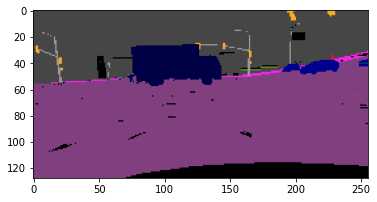

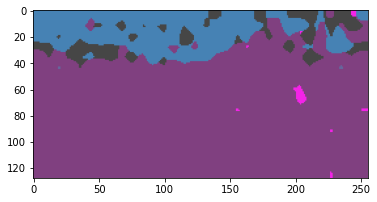

In [ ]:
print(im.shape)
print(gt.shape)
print(pred.shape)
plt.imshow(colorize_mask(gt))
plt.show()
plt.imshow(colorize_mask(pred))
plt.show()

In [ ]:
print(label.dtype)
print(output.dtype)